# Militar Aircraft Detection

This notebook train the model to detect and classify combat aircraft and helicopters following the [Kaggle competion](https://www.kaggle.com/competitions/aa-iv-2025-i-object-localization)

## 1 Imports

Here we import all required modules from different libraries

In [ ]:
import os
import cv2
import math
import torch
import torchvision
from torchsummary import summary

import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations as A
import matplotlib.pyplot as plt

from skimage import io
from torch import Tensor
from functools import reduce
from torch.optim import Optimizer
from multiprocessing import cpu_count
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from sklearn.model_selection import train_test_split
from typing import Any, Callable, Dict, List, Optional, Tuple
import copy


## 2 Define global variables

Here we define all global variables for agile change on different executions.

In [ ]:
DATA_DIR = '/kaggle/input/aa-iv-2025-i-object-localization/' # Directory with the input data
WORK_DIR = '/kaggle/working' # Directory to use for output files
IMG_DIR = os.path.join(DATA_DIR, "images", "images") # Path to imgs

BATCH_SIZE = 32
EPOCHS = 200
ALPHA = 0.7             # Ponderation factor for classification and regression
LEARNING_RATE = 1e-4
L2_LAMBDA = 1e-6
PYTORCH_SEED = 32
SPLIT_SEED = 42
AUGMENTATIONS = 6

TARGET_SIZE = (400, 255)  # resize images (w, h)
H_REAL, W_REAL = 720, 1280  # Real image size

# Class map for encode and decode
OBJ2ID = {'f16': 0, 'cougar': 1, 'chinook': 2, 'ah64': 3, 'f15': 4, 'seahawk': 5}
ID2OBJ = {v: k for k, v in OBJ2ID.items()}

# verify if GPU is available to use
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

## 3 Utility functions for process and visualize images

Here we define the functions that allow images to be processed and visualize

In [ ]:
def normalize_bbox(bbox: np.ndarray, h: int, w: int) -> List[int]:
    """Converts normalized bounding box coordinates to integer values
    corresponding to the image dimensions.

    Args:
        bbox (np.ndarray): Normalized bounding box coordinates [xmin, ymin, xmax, ymax].
        h (int): Height of the image.
        w (int): Width of the image.

    Returns:
        List[int]: Bounding box coordinates as integers [xmin, ymin, xmax, ymax].
    """
    return [
            int(bbox[0] * w),
            int(bbox[1] * h),
            int(bbox[2] * w),
            int(bbox[3] * h),
        ]

def draw_bbox(img: np.ndarray, bbox: List[int], color: Tuple[int, int, int], thickness: int = 3) -> np.ndarray:
    """Draws a bounding box on the image using OpenCV.

    Args:
        img (np.ndarray): The image to draw on.
        bbox (List[int]): Bounding box coordinates [xmin, ymin, xmax, ymax].
        color (Tuple[int, int, int]): Color of the bounding box.
        thickness (int, optional): Thickness of the bounding box lines. Defaults to 3.

    Returns:
        np.ndarray: The image with the bounding box drawn.
    """
    xmin, ymin, xmax, ymax = bbox
    return cv2.rectangle(img.copy(), (xmin, ymin), (xmax, ymax), color, thickness)

def draw_bboxes(imgs: List[np.ndarray], bboxes: List[List[int]], colors: List[Tuple[int, int, int]], thickness: int) -> List[np.ndarray]:
    """Draws multiple bounding boxes on a list of images.

    Args:
        imgs (List[np.ndarray]): List of images to draw on.
        bboxes (List[List[int]]): List of bounding box coordinates for each image.
        colors (List[Tuple[int, int, int]]): List of colors for the bounding boxes.
        thickness (int): Thickness of the bounding box lines.

    Returns:
        List[np.ndarray]: List of images with bounding boxes drawn.
    """
    return [draw_bbox(img, bbox, colors[min(i, len(colors) - 1)], thickness)
            for i, (img, bbox) in enumerate(zip(imgs, bboxes))]

def draw_classes(imgs: List[np.ndarray], classes: List[np.ndarray], colors: List[Tuple[int, int, int]], origin: Tuple[int, int],
                 prefix: str = '', fontScale: int = 2) -> List[np.ndarray]:
    """Adds class labels to images at a specified position.

    Args:
        imgs (List[np.ndarray]): List of images to add labels to.
        classes (List[np.ndarray]): List of class IDs or one-hot encoded class labels for each image.
        colors (List[Tuple[int, int, int]]): List of colors for the labels.
        origin (Tuple[int, int]): Position (x, y) to place the label on the image.
        prefix (str, optional): Prefix to add before the class label. Defaults to ''.
        fontScale (int, optional): Font scale for the label text. Defaults to 2.

    Returns:
        List[np.ndarray]: List of images with class labels added.
    """
    for i, (img, cls) in enumerate(zip(imgs, classes)):
        class_id = cls[0] if isinstance(cls, (list, np.ndarray)) else cls
        text = f"{prefix}{ID2OBJ[class_id]}"
        imgs[i] = cv2.putText(
            img.copy(), text, origin, cv2.FONT_HERSHEY_SIMPLEX,
            fontScale, colors[min(i, len(colors) - 1)], 2, cv2.LINE_AA
        )
    return imgs

def draw_predictions(imgs: List[np.ndarray], classes: List[Any], bboxes: List[List[int]],
                     colors: List[Tuple[int, int, int]], origin: Tuple[int, int],
                     thickness: int, fontScale: int) -> List[np.ndarray]:
    """Draws both bounding boxes and class labels on images.

    Args:
        imgs (List[np.ndarray]): List of images to draw on.
        classes (List[Any]): List of class IDs or one-hot encoded class labels for each image.
        bboxes (List[List[int]]): List of bounding box coordinates for each image.
        colors (List[Tuple[int, int, int]]): List of colors for the bounding boxes and labels.
        origin (Tuple[int, int]): Position (x, y) to place the label on the image.
        thickness (int): Thickness of the bounding box lines.
        fontScale (int): Font scale for the label text.

    Returns:
        List[np.ndarray]: List of images with bounding boxes and class labels drawn.
    """
    imgs_with_boxes = draw_bboxes(imgs, bboxes, colors, thickness)
    imgs_with_labels = draw_classes(imgs_with_boxes, classes, colors, origin, fontScale=fontScale)
    return imgs_with_labels


In [ ]:
def load_annotations(csv_path: str) -> pd.DataFrame:
    """Loads annotations from a CSV file and assigns class IDs.

    Args:
        csv_path (str): Path to the CSV file containing annotations.

    Returns:
        pd.DataFrame: DataFrame containing the annotations with assigned class IDs.
    """
    df = pd.read_csv(csv_path)
    df["class_id"] = df["class"].map(OBJ2ID)
    cols = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class', 'class_id']
    return df[cols].copy()

def normalize_bboxes(df: pd.DataFrame, h_real: int, w_real: int) -> pd.DataFrame:
    """Normalizes bounding box coordinates by dividing by the real image dimensions.

    Args:
        df (pd.DataFrame): DataFrame containing bounding box coordinates.
        h_real (int): Real height of the image.
        w_real (int): Real width of the image.

    Returns:
        pd.DataFrame: DataFrame with normalized bounding box coordinates.
    """
    df[["ymin", "ymax"]] = df[["ymin", "ymax"]].div(h_real, axis=0)
    df[["xmin", "xmax"]] = df[["xmin", "xmax"]].div(w_real, axis=0)
    return df

## 4 Class to manage the dataset

Here we define a class that represents the dataset of images.

In [ ]:
class MilitaryDataset(Dataset):
    """
    Represents a dataset for military object detection.

    Args:
        df (pd.DataFrame): DataFrame with image url and labels (optional).
        root_dir (str): Directory with the images.
        labeled (bool, optional): Indicate if dataframe includes labels (bounding boxes and class). Defaults to True.
        transform (Optional[Callable[[Dict[str, Any]], Dict[str, Any]]], optional): Function with transformation to apply on images. Defaults to None.
        output_size (Optional[Tuple[int, int]], optional): Expected size for the images. Defaults to None.
        augment_times (int, optional): Number of augmentations for an image. Defaults to 1.
    """
    def __init__(
        self,
        df: 'pd.DataFrame',
        root_dir: str,
        labeled: bool = True,
        transform: Optional[Callable[[Dict[str, Any]], Dict[str, Any]]] = None,
        output_size: Optional[Tuple[int, int]] = None,
        augment_times: int = 1
    ):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.labeled = labeled
        self.transform = transform
        self.output_size = output_size
        self.augment_times = augment_times

    def __len__(self) -> int:
        """
        Returns the total number of images including images.
        """
        return len(self.df) * self.augment_times

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Returns a sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            Dict[str, Any]: A dictionary containing the image and labels (if labeled).
        """
        if torch.is_tensor(idx):
            idx = int(idx.tolist())
        base_idx = idx // self.augment_times
        row = self.df.iloc[base_idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        image = io.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        # Convert from grayscale to RGB or remove alpha channel
        if image.ndim == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:
            image = image[:, :, :3]
        # Resize image
        if self.output_size:
            image = cv2.resize(image, self.output_size)
        sample = {'image': image}
        if self.labeled:
            bbox = row[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy(dtype=float)
            cls_id = row['class_id']
            sample.update({
                'bbox': np.array([bbox]),
                'class_id': cls_id
            })
        # Apply given transformations
        if self.transform:
            sample = self.transform(sample)
        return sample

## 5 Utilities for image transformation

Here we define the classes to apply different transformations to the images.

- **ToTensor**: Required transformation by pytorch to process the images with the required form (batch, channel, width, height).
- **Normalizer**: Suggested transformation to apply for normalize image to improve model convergence and stability.
- **AlbumentationsWrapper**: Optional transformation focus on image augmentation to create new samples on the existing data

In [ ]:
class ToTensor(object):
    """
    Converts a NumPy array image to a PyTorch tensor.
    """
    def __call__(self, sample: Dict[str, Any]) -> Dict[str, Any]:
        """
        Applies the transformation to the sample.

        Args:
            sample (Dict[str, Any]): A dictionary containing the image.

        Returns:
            Dict[str, Any]: A dictionary containing the transformed image.
        """
        image = sample['image']
        image = image.transpose((2, 0, 1))
        sample['image'] = torch.from_numpy(image).float()
        return sample

class Normalizer(object):
    """
    Normalizes an image using provided means and standard deviations.

    Args:
        means (np.ndarray): Means for each channel.
        stds (np.ndarray): Standard deviations for each channel.
    """
    def __init__(self, means: np.ndarray, stds: np.ndarray):
        self.means = means
        self.stds = stds

    def __call__(self, sample: Dict[str, Any]) -> Dict[str, Any]:
        """
        Applies the normalization to the sample.

        Args:
            sample (Dict[str, Any]): A dictionary containing the image.

        Returns:
            Dict[str, Any]: A dictionary containing the normalized image.
        """
        image = sample['image']
        for channel in range(image.shape[0]):
            image[channel] = (image[channel] - self.means[channel]) / self.stds[channel]
        sample['image'] = image
        return sample

class AlbumentationsWrapper(object):
    """
    Wraps Albumentations transforms for compatibility with the dataset.

    Args:
        transform (A.Compose): Albumentations transform pipeline.
    """
    def __init__(self, transform: A.Compose):
        self.transform = transform

    def __call__(self, sample: Dict[str, Any]) -> Dict[str, Any]:
        """
        Applies the Albumentations transform to the sample.

        Args:
            sample (Dict[str, Any]): A dictionary containing the image and bounding boxes.

        Returns:
            Dict[str, Any]: A dictionary containing the transformed image and bounding boxes.
        """
        transformed = self.transform(
            image=sample['image'],
            bboxes=sample['bbox'],
        )
        sample['image'] = transformed['image']
        bboxes = transformed['bboxes']
        # Fusiona múltiples bounding boxes si es necesario
        if len(bboxes) > 1:
            xs = [bbox[0] for bbox in bboxes] + [bbox[2] for bbox in bboxes]
            ys = [bbox[1] for bbox in bboxes] + [bbox[3] for bbox in bboxes]
            merged_bbox = [min(xs), min(ys), max(xs), max(ys)]
            bboxes = [merged_bbox]
        elif len(bboxes) == 0:
            bboxes = sample['bbox']
        sample['bbox'] = np.array(bboxes)
        return sample

In [ ]:
def denormalize_image(image: torch.Tensor, means: list, stds: list) -> torch.Tensor:
    """Denormalizes an image using provided means and standard deviations.

    Args:
        image (torch.Tensor): The image to denormalize.
        means (list): Means for each channel.
        stds (list): Standard deviations for each channel.

    Returns:
        torch.Tensor: The denormalized image.
    """
    for channel in range(image.shape[0]):
        image[channel] = image[channel] * stds[channel] + means[channel]
    return image

The following cell is used to calculate the means and standard deviations per channel of dataset images so it can be used to normalize.

In [ ]:
def compute_image_stats(dataset: Dataset) -> Tuple[np.ndarray, np.ndarray]:
    """Calculates the means and standard deviations of images in the dataset.

    Args:
        dataset (Dataset): The dataset containing the images.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the means and standard deviations
                                        for each channel of the images.
    """
    means = np.zeros(3)
    stds = np.zeros(3)
    n_images = len(dataset)
    for sample in dataset:
        img = sample['image']
        for channel in range(3):
            means[channel] += np.mean(img[..., channel])
            stds[channel] += np.std(img[..., channel])
    means /= n_images
    stds /= n_images
    return means, stds

The following cell has a function to create an augmentation pipeline to apply transformations to the images

In [ ]:
def build_transforms(means: np.ndarray, stds: np.ndarray) -> Tuple[Callable, Callable]:
    """Builds and returns the transformation pipelines for training and evaluation.

    Args:
        means (np.ndarray): Means of the image channels.
        stds (np.ndarray): Standard deviations of the image channels.

    Returns:
        Tuple[Callable, Callable]: A tuple containing the training and evaluation transforms.
    """
    # Pipeline de aumentación con albumentations
    aug_pipeline = A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=0, p=0.5),
            A.Blur(blur_limit=3, p=0.5),
        ],
        bbox_params=A.BboxParams(format='albumentations', label_fields=[])
    )
    train_transforms = torchvision.transforms.Compose([
        AlbumentationsWrapper(aug_pipeline),
        ToTensor(),
        Normalizer(means, stds)
    ])
    eval_transforms = torchvision.transforms.Compose([
        ToTensor(),
        Normalizer(means, stds)
    ])
    return train_transforms, eval_transforms

Here we apply the following transformation to images with a probability of 50% to be applied.

- **HorizontalFlip**: This change the orientation of the image horizontally so the aircraft can be seen in both directions by the model.
- **RandomBrightnessContrast**: Randomly apply brigthness and contrast to the image to add some noise presented on the sky.
- **Rotate**: Rotate images randomly with a max 15 degrees clock whise or counter whise.
- **ShiftScaleRotate**: Randomly translate vertical and horizontally, scale it 0.1 and rotate it 15 degrees. This allows the model to explore the aircrafts in different common positions.
- **Blur**: Randomly apply a blur to the image to simulate bad taken images.


## 6 Function to calculate metrics

Here we define the functions to calculate metrics for regression and classification.

- **IOU**: Calculate the intersection over union for the bounding box of the image.
- **accuracy**: Calculate class prediction accuracy

In [ ]:
def iou(y_true: Tensor, y_pred: Tensor) -> Tensor:
    """Calculates the Intersection over Union (IoU) between true and predicted bounding boxes.

    Args:
        y_true (Tensor): True bounding boxes.
        y_pred (Tensor): Predicted bounding boxes.

    Returns:
        Tensor: IoU score.
    """
    pairwise_iou = torchvision.ops.box_iou(y_true.squeeze(), y_pred.squeeze())
    return torch.trace(pairwise_iou) / pairwise_iou.size(0)

def accuracy(y_true: Tensor, y_pred: Tensor) -> Tensor:
    """Calculates the accuracy of class predictions.

    Args:
        y_true (Tensor): True class labels.
        y_pred (Tensor): Predicted class logits.

    Returns:
        Tensor: Accuracy score.
    """
    pred = torch.argmax(y_pred, dim=-1)
    y_true = y_true.squeeze()
    correct = (pred == y_true).float()
    return correct.mean()

## 7 Utilities to create and train the model

### 7.1 pretrained model features, extractor and Model initialization

Here we create the class to extract features on a pretrained model and freeze specific layers to avoid update weigths when training the final layers focus on our specific task.

Also We create the multi task model we are going to train to predict class and bounding box.

**Feature Extractor**

receives the number of layers to freeze and automatically separate them following the best practices to freeze first layers and train the last ones to better fit the use case. By default it will train all layers.

The initial architecture includes.

- features layers of the pre trained model (validate how the model you want to use has this layers define since some may use a different name)
- average pool layer include in the pretrained model (validate the model you want to use has this layer and modify has required)
- Flatten layer to pass from 2D to 1D
- Dropout with 0.5 to avoid overfitting

**MultiTaskModel**

Model with a classification head and a regression head to predict class and bounding boxes. Each head may have a different architecture and continue from the feature extractor layers.

#### VGG16 Features

```
 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU(inplace=True)
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU(inplace=True)
  (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (22): ReLU(inplace=True)
  (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (25): ReLU(inplace=True)
  (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (27): ReLU(inplace=True)
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): ReLU(inplace=True)
  (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 )
```

#### VGG19 Features



```
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU(inplace=True)
  (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (22): ReLU(inplace=True)
  (23): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (24): ReLU(inplace=True)
  (25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (26): ReLU(inplace=True)
  (27): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): ReLU(inplace=True)
  (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (31): ReLU(inplace=True)
  (32): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (33): ReLU(inplace=True)
  (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (35): ReLU(inplace=True)
  (36): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
```



#### EfficientNetV2-s Features



```
Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.005, mode=row)
    )
  )
  (2): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.01, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.015000000000000003, mode=row)
    )
    (2): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.02, mode=row)
    )
    (3): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.025, mode=row)
    )
  )
  (3): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.030000000000000006, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.035, mode=row)
    )
    (2): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.04, mode=row)
    )
    (3): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.045, mode=row)
    )
  )
  (4): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=256, bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.05, mode=row)
    )
    (1): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512, bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.05500000000000001, mode=row)
    )
    (2): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512, bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.06000000000000001, mode=row)
    )
    (3): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512, bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.065, mode=row)
    )
    (4): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512, bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.07, mode=row)
    )
    (5): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512, bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.075, mode=row)
    )
  )
  (5): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(128, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(768, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(768, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=768, bias=False)
          (1): BatchNorm2d(768, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(768, 32, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(32, 768, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(768, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.08, mode=row)
    )
    (1): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.085, mode=row)
    )
    (2): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.09, mode=row)
    )
    (3): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.095, mode=row)
    )
    (4): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.1, mode=row)
    )
    (5): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.10500000000000001, mode=row)
    )
    (6): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.11000000000000001, mode=row)
    )
    (7): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.11500000000000002, mode=row)
    )
    (8): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.12000000000000002, mode=row)
    )
  )
  (6): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=960, bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(960, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.125, mode=row)
    )
    (1): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.13, mode=row)
    )
    (2): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.135, mode=row)
    )
    (3): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.14, mode=row)
    )
    (4): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.14500000000000002, mode=row)
    )
    (5): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.15, mode=row)
    )
    (6): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.155, mode=row)
    )
    (7): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.16, mode=row)
    )
    (8): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.165, mode=row)
    )
    (9): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.17, mode=row)
    )
    (10): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.175, mode=row)
    )
    (11): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.18, mode=row)
    )
    (12): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.185, mode=row)
    )
    (13): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.19, mode=row)
    )
    (14): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(256, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1536, bias=False)
          (1): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.195, mode=row)
    )
  )
  (7): Conv2dNormActivation(
    (0): Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
)
```



#### EfficientNetV2-m features



```
Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0035087719298245615, mode=row)
    )
    (2): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.007017543859649123, mode=row)
    )
  )
  (2): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.010526315789473686, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.014035087719298246, mode=row)
    )
    (2): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.017543859649122806, mode=row)
    )
    (3): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.02105263157894737, mode=row)
    )
    (4): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.024561403508771933, mode=row)
    )
  )
  (3): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(48, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(192, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.028070175438596492, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(80, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(320, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.031578947368421054, mode=row)
    )
    (2): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(80, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(320, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.03508771929824561, mode=row)
    )
    (3): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(80, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(320, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.03859649122807018, mode=row)
    )
    (4): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(80, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(320, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.04210526315789474, mode=row)
    )
  )
  (4): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(320, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(320, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=320, bias=False)
          (1): BatchNorm2d(320, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(320, 20, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(20, 320, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(320, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0456140350877193, mode=row)
    )
    (1): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 640, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=640, bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(640, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 640, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(640, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.04912280701754387, mode=row)
    )
    (2): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 640, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=640, bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(640, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 640, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(640, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.05263157894736842, mode=row)
    )
    (3): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 640, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=640, bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(640, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 640, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(640, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.056140350877192984, mode=row)
    )
    (4): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 640, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=640, bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(640, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 640, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(640, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.05964912280701755, mode=row)
    )
    (5): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 640, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=640, bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(640, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 640, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(640, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.06315789473684211, mode=row)
    )
    (6): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 640, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=640, bias=False)
          (1): BatchNorm2d(640, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(640, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 640, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(640, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.06666666666666667, mode=row)
    )
  )
  (5): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
          (1): BatchNorm2d(960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(960, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.07017543859649122, mode=row)
    )
    (1): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0736842105263158, mode=row)
    )
    (2): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.07719298245614035, mode=row)
    )
    (3): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.08070175438596493, mode=row)
    )
    (4): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.08421052631578949, mode=row)
    )
    (5): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.08771929824561403, mode=row)
    )
    (6): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0912280701754386, mode=row)
    )
    (7): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.09473684210526316, mode=row)
    )
    (8): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.09824561403508773, mode=row)
    )
    (9): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.10175438596491229, mode=row)
    )
    (10): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.10526315789473684, mode=row)
    )
    (11): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.10877192982456141, mode=row)
    )
    (12): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.11228070175438597, mode=row)
    )
    (13): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 176, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(176, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.11578947368421054, mode=row)
    )
  )
  (6): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(176, 1056, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1056, 1056, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=1056, bias=False)
          (1): BatchNorm2d(1056, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1056, 44, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(44, 1056, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1056, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.1192982456140351, mode=row)
    )
    (1): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.12280701754385964, mode=row)
    )
    (2): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.12631578947368421, mode=row)
    )
    (3): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.1298245614035088, mode=row)
    )
    (4): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.13333333333333333, mode=row)
    )
    (5): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.1368421052631579, mode=row)
    )
    (6): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.14035087719298245, mode=row)
    )
    (7): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.14385964912280705, mode=row)
    )
    (8): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.1473684210526316, mode=row)
    )
    (9): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.15087719298245614, mode=row)
    )
    (10): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.1543859649122807, mode=row)
    )
    (11): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.15789473684210525, mode=row)
    )
    (12): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.16140350877192985, mode=row)
    )
    (13): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.1649122807017544, mode=row)
    )
    (14): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.16842105263157897, mode=row)
    )
    (15): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.17192982456140352, mode=row)
    )
    (16): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.17543859649122806, mode=row)
    )
    (17): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 304, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(304, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.17894736842105266, mode=row)
    )
  )
  (7): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(304, 1824, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(1824, 1824, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1824, bias=False)
          (1): BatchNorm2d(1824, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(1824, 76, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(76, 1824, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(1824, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.1824561403508772, mode=row)
    )
    (1): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(512, 3072, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(3072, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(3072, 3072, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3072, bias=False)
          (1): BatchNorm2d(3072, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(3072, 128, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(128, 3072, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(3072, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.18596491228070178, mode=row)
    )
    (2): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(512, 3072, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(3072, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(3072, 3072, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3072, bias=False)
          (1): BatchNorm2d(3072, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(3072, 128, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(128, 3072, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(3072, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.18947368421052632, mode=row)
    )
    (3): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(512, 3072, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(3072, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(3072, 3072, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3072, bias=False)
          (1): BatchNorm2d(3072, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(3072, 128, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(128, 3072, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(3072, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.19298245614035087, mode=row)
    )
    (4): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(512, 3072, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(3072, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(3072, 3072, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3072, bias=False)
          (1): BatchNorm2d(3072, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (2): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(3072, 128, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(128, 3072, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (3): Conv2dNormActivation(
          (0): Conv2d(3072, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.19649122807017547, mode=row)
    )
  )
  (8): Conv2dNormActivation(
    (0): Conv2d(512, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
)```



#### MobileNetV3 small Features



```
Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        (activation): ReLU()
        (scale_activation): Hardsigmoid()
      )
      (2): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (2): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(72, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=72, bias=False)
        (1): BatchNorm2d(72, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2): Conv2dNormActivation(
        (0): Conv2d(72, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (3): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(88, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(88, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=88, bias=False)
        (1): BatchNorm2d(88, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2): Conv2dNormActivation(
        (0): Conv2d(88, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (4): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(96, 96, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=96, bias=False)
        (1): BatchNorm2d(96, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (2): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1))
        (activation): ReLU()
        (scale_activation): Hardsigmoid()
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(96, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (5): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(40, 240, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(240, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(240, 240, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=240, bias=False)
        (1): BatchNorm2d(240, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (2): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(240, 64, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(64, 240, kernel_size=(1, 1), stride=(1, 1))
        (activation): ReLU()
        (scale_activation): Hardsigmoid()
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(240, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (6): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(40, 240, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(240, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(240, 240, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=240, bias=False)
        (1): BatchNorm2d(240, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (2): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(240, 64, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(64, 240, kernel_size=(1, 1), stride=(1, 1))
        (activation): ReLU()
        (scale_activation): Hardsigmoid()
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(240, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (7): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(40, 120, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(120, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(120, 120, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=120, bias=False)
        (1): BatchNorm2d(120, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (2): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(120, 32, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(32, 120, kernel_size=(1, 1), stride=(1, 1))
        (activation): ReLU()
        (scale_activation): Hardsigmoid()
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(120, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (8): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(48, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(144, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(144, 144, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=144, bias=False)
        (1): BatchNorm2d(144, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (2): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(144, 40, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(40, 144, kernel_size=(1, 1), stride=(1, 1))
        (activation): ReLU()
        (scale_activation): Hardsigmoid()
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(144, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (9): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(48, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(288, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(288, 288, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=288, bias=False)
        (1): BatchNorm2d(288, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (2): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(288, 72, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(72, 288, kernel_size=(1, 1), stride=(1, 1))
        (activation): ReLU()
        (scale_activation): Hardsigmoid()
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(288, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (10): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(576, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(576, 576, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=576, bias=False)
        (1): BatchNorm2d(576, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (2): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(576, 144, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(144, 576, kernel_size=(1, 1), stride=(1, 1))
        (activation): ReLU()
        (scale_activation): Hardsigmoid()
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(576, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (11): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(576, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(576, 576, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=576, bias=False)
        (1): BatchNorm2d(576, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (2): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(576, 144, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(144, 576, kernel_size=(1, 1), stride=(1, 1))
        (activation): ReLU()
        (scale_activation): Hardsigmoid()
      )
      (3): Conv2dNormActivation(
        (0): Conv2d(576, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (12): Conv2dNormActivation(
    (0): Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(576, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
)
```



#### MobileNet V2 Features



```
Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (3): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(144, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (4): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(144, 144, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=144, bias=False)
        (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(144, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (5): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (6): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (7): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=192, bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (8): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (9): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (10): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (11): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (12): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(576, 576, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=576, bias=False)
        (1): BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(576, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (13): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(576, 576, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=576, bias=False)
        (1): BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(576, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (14): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(576, 576, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=576, bias=False)
        (1): BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(576, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (15): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
        (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (16): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
        (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (17): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2dNormActivation(
        (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
        (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(960, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (18): Conv2dNormActivation(
    (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
)
```



#### SqueezeNet 1.0



```
Sequential(
  (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (5): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (7): Fire(
    (squeeze): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (8): Fire(
    (squeeze): Conv2d(256, 48, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (9): Fire(
    (squeeze): Conv2d(384, 48, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (10): Fire(
    (squeeze): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (12): Fire(
    (squeeze): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
)
```



#### SqueezeNet 1.1



```
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (6): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (7): Fire(
    (squeeze): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (9): Fire(
    (squeeze): Conv2d(256, 48, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (10): Fire(
    (squeeze): Conv2d(384, 48, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (11): Fire(
    (squeeze): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (12): Fire(
    (squeeze): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
)
```



#### Swin transformer



```
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): Permute()
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (1): Sequential(
    (0): SwinTransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=128, out_features=384, bias=True)
        (proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=512, out_features=128, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (1): SwinTransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=128, out_features=384, bias=True)
        (proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.021739130434782608, mode=row)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=512, out_features=128, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (2): PatchMerging(
    (reduction): Linear(in_features=512, out_features=256, bias=False)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (3): Sequential(
    (0): SwinTransformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.043478260869565216, mode=row)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (1): SwinTransformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.06521739130434782, mode=row)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (4): PatchMerging(
    (reduction): Linear(in_features=1024, out_features=512, bias=False)
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (5): Sequential(
    (0): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.08695652173913043, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (1): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.10869565217391304, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (2): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.13043478260869565, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (3): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.15217391304347827, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (4): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.17391304347826086, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (5): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.1956521739130435, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (6): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.21739130434782608, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (7): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.2391304347826087, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (8): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.2608695652173913, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (9): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.2826086956521739, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (10): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.30434782608695654, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (11): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.32608695652173914, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (12): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.34782608695652173, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (13): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.3695652173913043, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (14): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.391304347826087, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (15): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.41304347826086957, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (16): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.43478260869565216, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (17): SwinTransformerBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.45652173913043476, mode=row)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (6): PatchMerging(
    (reduction): Linear(in_features=2048, out_features=1024, bias=False)
    (norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (7): Sequential(
    (0): SwinTransformerBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.4782608695652174, mode=row)
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=4096, out_features=1024, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (1): SwinTransformerBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.5, mode=row)
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=4096, out_features=1024, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
  )
)
```



#### Get pre trained model

In [ ]:
def get_pretrained_model(model_name: str = 'vgg16', freeze_until: int = -1) -> nn.Module:
    """Creates a feature extractor from a pre-trained model.

    Args:
        model_name (str, optional): Name of the pre-trained model to use.
            Valid options are: 'vgg16', 'vgg19', 'efficientnet_v2_s', 'EfficientNetV2_m, 'MobileNetV2', 'MobileNetV3_small','SqueezeNet1_0','SqueezeNet1_1','SwinTransformer'.
            Defaults to 'vgg16'.
        freeze_until (int, optional): Index of the last layer to freeze. Defaults to -1 (no freezing).

    Returns:
        nn.Module: The pre-trained model.
    """
    model = None
    if model_name == 'VGG16':
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    elif model_name == 'VGG19':
        model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    elif model_name == 'EfficientNetV2_s':
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
    elif model_name == 'EfficientNetV2_m':
        model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
    elif model_name == 'MobileNetV2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    elif model_name == 'MobileNetV3_small':
        model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
    elif model_name == 'SqueezeNet1_0':
        model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)
    elif model_name == 'SqueezeNet1_1':
        model = models.squeezenet1_1(weights = models.SqueezeNet1_1_Weights.DEFAULT)
    elif model_name == 'SwinTransformer':
        model = models.swin_b(weights=models.Swin_B_Weights.DEFAULT)

    if model is not None:
        return FeatureExtractor(model, freeze_until)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

### 7.2 Initialize model

In [ ]:
class FeatureExtractor(nn.Module):
    """
    Extracts features using the convolutional part of a model.
    Allows freezing layers up to a given index.

    Args:
        model (nn.Module): The model to extract features from.
        freeze_until (int, optional): Index of the last layer to freeze. Defaults to -1 (no freezing).
    """
    def __init__(self, model: nn.Module, freeze_until: int = -1):
        super().__init__()
        all_features = list(model.features)
        if freeze_until >= 0:
            self.frozen = nn.Sequential(*all_features[:freeze_until+1])
            self.trainable = nn.Sequential(*all_features[freeze_until+1:])
            for param in self.frozen.parameters():
                param.requires_grad_(False)
        else:
            self.features = nn.Sequential(*all_features)
        # Check if the pretrained model has an avgpool layer
        if hasattr(model, 'avgpool'):
            self.pooling = model.avgpool
        else:
            # If not, use PyTorch's AdaptiveAvgPool2d
            self.pooling = nn.AdaptiveAvgPool2d((7, 7))

        self.freeze_until = freeze_until

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the feature extractor.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Extracted features.
        """
        if hasattr(self, 'frozen'):
            x = self.frozen(x)
            x = self.trainable(x)
        else:
            x = self.features(x)
        return self.pooling(x)

class MultiTaskModel(nn.Module):
    """
    Multi-task model for classification and bounding box regression.
    Uses VGG16 with pretrained weights as the backbone if not provided.

    Args:
        input_shape (Tuple[int, int, int], optional): Input shape of the images. Defaults to (3, TARGET_SIZE[1], TARGET_SIZE[0]).
        n_classes (int, optional): Number of classes. Defaults to 6.
        backbone (Optional[nn.Module], optional): Backbone model to use. Defaults to None.
    """
    def __init__(self, input_shape: Tuple[int, int, int] = (3, TARGET_SIZE[1], TARGET_SIZE[0]),
                 n_classes: int = 6, backbone: Optional[nn.Module] = None):
        super().__init__()
        self.input_shape = input_shape
        if backbone is None:
            vgg = vgg16(weights=VGG16_Weights.DEFAULT)
            backbone = FeatureExtractor(vgg, freeze_until=15)
        self.backbone = backbone.to(DEVICE)
        dummy_input = torch.rand(1, *input_shape).to(DEVICE)
        backbone_out_shape = self.backbone(dummy_input).shape
        flattened_features = reduce(lambda x, y: x * y, backbone_out_shape[1:])
        self.cls_head = nn.Sequential(
            nn.Conv2d(in_channels=backbone_out_shape[1], out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=n_classes, kernel_size=1),
            nn.AdaptiveMaxPool2d((1, 1))
        )

        self.reg_head = nn.Sequential(
            nn.Conv2d(in_channels=backbone_out_shape[1], out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=4, kernel_size=1),
            nn.AdaptiveMaxPool2d((1, 1))
        )


    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        """
        Forward pass of the multi-task model.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Dict[str, Tensor]: A dictionary containing class logits and bounding box predictions.
        """
        features = self.backbone(x)
        cls_logits = self.cls_head(features)
        bbox_pred = torch.sigmoid(self.reg_head(features))
        return {'class_id': cls_logits, 'bbox': bbox_pred}

### 7.3 loss functions

Here we create a loss function for the bounding boxes based on the iou. And a combined loss of cross entropy for clasification and custom iou loss for bounding box, we stablish an alpha to weight the combination, alpha 0 use classification loss only while alpha 1 use iou loss only.

In [ ]:
def iou_loss(y_true: Tensor, y_pred: Tensor) -> Tensor:
    """Calculates the Intersection over Union (IoU) loss for bounding boxes.

    Args:
        y_true (Tensor): True bounding boxes.
        y_pred (Tensor): Predicted bounding boxes.

    Returns:
        Tensor: IoU loss.
    """
    if y_true.dim() == 1:
        y_true = y_true.unsqueeze(0)
    if y_pred.dim() == 1:
        y_pred = y_pred.unsqueeze(0)
    xA = torch.max(y_true[:, 0], y_pred[:, 0])
    yA = torch.max(y_true[:, 1], y_pred[:, 1])
    xB = torch.min(y_true[:, 2], y_pred[:, 2])
    yB = torch.min(y_true[:, 3], y_pred[:, 3])
    inter_width = (xB - xA).clamp(min=0)
    inter_height = (yB - yA).clamp(min=0)
    inter_area = inter_width * inter_height
    area_true = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    area_pred = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])
    union_area = area_true + area_pred - inter_area + 1e-6
    iou = inter_area / union_area
    loss = 1 - iou.mean()
    return loss

def loss_fn(y_true: Dict[str, Tensor], y_preds: Dict[str, Tensor], alpha: float = ALPHA) -> Dict[str, Tensor]:
    """Calculates the combined loss for classification and regression (IoU).

    Args:
        y_true (Dict[str, Tensor]): Dictionary containing true class IDs and bounding boxes.
        y_preds (Dict[str, Tensor]): Dictionary containing predicted class logits and bounding boxes.
        alpha (float, optional): Weighting factor for the regression loss. Defaults to ALPHA.

    Returns:
        Dict[str, Tensor]: Dictionary containing the total loss, classification loss, and regression loss.
    """
    cls_y_true = y_true['class_id'].long()
    cls_y_pred = y_preds['class_id']
    reg_y_true = y_true['bbox'].float().squeeze()
    reg_y_pred = y_preds['bbox'].float().squeeze()
    cls_loss = torch.nn.functional.cross_entropy(cls_y_pred, cls_y_true)
    reg_loss = iou_loss(reg_y_true,reg_y_pred)
    total_loss = (1 - alpha) * cls_loss + alpha * reg_loss
    return {'loss': total_loss, 'cls_loss': cls_loss, 'reg_loss': reg_loss}

### 7.4 Training functions

In [ ]:
def evaluate(
    logs: Dict[str, Any],
    labels: Dict[str, Tensor],
    preds: Dict[str, Tensor],
    eval_set: str,
    metrics: Dict[str, List[Tuple[str, Callable[[Tensor, Tensor], Tensor]]]],
    losses: Optional[Dict[str, Tensor]] = None
) -> Dict[str, Any]:
    """Evaluates the model using defined metrics and updates the logs dictionary.

    Args:
        logs (Dict[str, Any]): Dictionary to store evaluation results.
        labels (Dict[str, Tensor]): Dictionary containing true labels.
        preds (Dict[str, Tensor]): Dictionary containing model predictions.
        eval_set (str): Name of the evaluation set (e.g., 'train', 'val').
        metrics (Dict[str, List[Tuple[str, Callable[[Tensor, Tensor], Tensor]]]]): Dictionary of metrics to calculate.
        losses (Optional[Dict[str, Tensor]], optional): Dictionary of losses. Defaults to None.

    Returns:
        Dict[str, Any]: Updated logs dictionary with evaluation results.
    """
    if losses is not None:
        for loss_name, loss_value in losses.items():
            key = f'{eval_set}_{loss_name}'
            if key in logs:
                logs[key] += loss_value.item() if torch.is_tensor(loss_value) else loss_value
            else:
                logs[key] = loss_value.item() if torch.is_tensor(loss_value) else loss_value
    for task_name, label in labels.items():
        for metric_name, metric in metrics[task_name]:
            key = f'{eval_set}_{metric_name}'
            value = metric(label, preds[task_name])
            if key in logs:
                logs[key] += value.item() if torch.is_tensor(value) else value
            else:
                logs[key] = value.item() if torch.is_tensor(value) else value
    return logs

def training_step(model: nn.Module, optimizer: Optimizer, batch: Dict[str, Any],
                  loss_fn: Callable, device: str, train: bool = False) -> Tuple[Dict[str, Tensor], Dict[str, Tensor]]:
    """Performs a single training or evaluation step.

    Args:
        model (nn.Module): The model to train or evaluate.
        optimizer (Optimizer): The optimizer used for training.
        batch (Dict[str, Any]): A batch of data containing images and labels.
        loss_fn (Callable): The loss function to use.
        device (str): The device to use for computation ('cpu' or 'cuda').
        train (bool, optional): Whether to perform a training step (True) or an evaluation step (False). Defaults to False.

    Returns:
        Tuple[Dict[str, Tensor], Dict[str, Tensor]]: A tuple containing the calculated losses and model predictions.
    """
    if train:
        optimizer.zero_grad()
    img = batch.pop('image').to(device)
    for key in batch:
        batch[key] = batch[key].to(device)
    preds = model(img.float())
    losses = loss_fn(batch, preds)
    if train:
        losses['loss'].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    return losses, preds

def train_model(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: DataLoader,
    eval_loaders: List[Tuple[str, DataLoader]],
    loss_fn: Callable,
    metrics: Dict[str, List[Tuple[str, Callable[[Tensor, Tensor], Tensor]]]],
    callbacks: List[Callable[[Dict[str, Any]], None]],
    device: str,
    epochs: int = 10,
    patience: int = 10
) -> nn.Module:
    """Trains the model for a specified number of iterations.

    Args:
        model (nn.Module): The model to train.
        optimizer (Optimizer): The optimizer to use for training.
        train_loader (DataLoader): DataLoader for the training dataset.
        eval_loaders (List[Tuple[str, DataLoader]]): List of DataLoaders for evaluation datasets.
        loss_fn (Callable): The loss function to use.
        metrics (Dict[str, List[Tuple[str, Callable[[Tensor, Tensor], Tensor]]]]): Dictionary of metrics to calculate during evaluation.
        callbacks (List[Callable[[Dict[str, Any]], None]]): List of callback functions to execute during training.
        device (str): The device to use for computation ('cpu' or 'cuda').
        epochs (int, optional): Total number of epochs. Defaults to 10.
        patience (int, optional): Number of epochs to wait for improvement in validation loss before early stopping. Defaults to 10.

    Returns:
        nn.Module: The trained model.
    """
    model = model.to(device)
    best_val_loss = float('inf')  # Initialize with a very large value
    patience_counter = 0
    best_model = None

    for epoch in range(epochs):
        model.train()
        logs: Dict[str, Any] = {'train_iter': 0, 'epoch': epoch}
        for iters, batch in enumerate(train_loader):  # Iterate through batches in the epoch
            losses, preds = training_step(model, optimizer, batch, loss_fn, device, train=True)
            logs = evaluate(logs, batch, preds, 'train', metrics, losses)
            logs['train_iter'] += 1

        # Evaluation at the end of each epoch
        model.eval()
        with torch.no_grad():
            for name, loader in eval_loaders:
                logs[f'{name}_iter'] = 0
                for eval_batch in loader:
                    eval_losses, eval_preds = training_step(model, optimizer, eval_batch, loss_fn, device, train=False)
                    logs = evaluate(logs, eval_batch, eval_preds, name, metrics, eval_losses)
                    logs[f'{name}_iter'] += 1

        for callback in callbacks:
            callback(logs)

        # Early Stopping Check
        val_loss = logs['val_loss'] / logs['val_iter']  # Get average validation loss for the epoch
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            best_model = copy.deepcopy(model)  # Save the best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                print(f"Best epoch was: {(epoch - patience)+1}")
                break  # Exit training loop

    return best_model

### 7.5 Callbacks

In [ ]:
def print_callback(logs: Dict[str, Any]) -> None:
    """
    Callback function to print training and validation logs.

    Args:
        logs (Dict[str, Any]): Dictionary containing training logs.
    """
    print(f"Epoch {logs['epoch']+1}:")
    for key, value in logs.items():
        if key != 'epoch' and not key.endswith('iter'):
            print(f"  {key} = {value / logs[key.split('_')[0] + '_iter']}")
    print()

In [ ]:
class TrainingMonitor:
    """
    Monitors and logs training progress, including metrics and visualizations.

    Args:
        log_dir (str): Directory to save logs and visualizations.
        metric_names (List[str], optional): Names of metrics to track. Defaults to ['loss', 'accuracy'].
        visualization_freq (int, optional): Frequency (in epochs) to generate visualizations. Defaults to 1.
    """
    def __init__(self):
        self.logs = {}

    def save_logs(self, logs):
        """
        Logs training and validation metrics for a given epoch.

        Args:
            epoch (int): Current epoch number.
            train_metrics (Dict[str, float]): Dictionary of training metrics.
            val_metrics (Dict[str, float]): Dictionary of validation metrics.
        """
        for key, value in logs.items():
            if key not in self.logs and key != 'epoch' and not key.endswith('iter'):
                self.logs[key] = []
            if key != 'epoch' and not key.endswith('iter'):
                self.logs[key].append(value / logs[key.split('_')[0] + '_iter'])

    def plot_logs(self):
        """
        Generates visualizations of training progress.

        Args:
            epoch (int): Current epoch number.
        """
        fig, axes = plt.subplots(3, 1, figsize=(15, 15))  # Create 3 subplots
        axes = axes.flatten()  # Flatten the axes array for easy indexing
        axes[0].set_title('Loss')
        axes[1].set_title('Accuracy')
        axes[2].set_title('IoU')

        for key in self.logs:
            if key != 'epoch' and not key.endswith('iter'):
                if key.endswith('loss'):
                    axes[0].plot(self.logs[key], label=key)
                elif key.endswith('accuracy'):
                    axes[1].plot(self.logs[key], label=key)
                elif key.endswith('iou'):
                    axes[2].plot(self.logs[key], label=key)

        for ax in axes:
            ax.legend()

        plt.tight_layout()
        plt.show()


## 8 Function to train the model

Here we load the train dataset and train the model like follows.

1. Load dataset
2. Normalize bounding boxes
3. Split dataset with 25% for validation
4. Generate dataset with the train split part
5. Calculate the mean and standard deviation of the train dataset to normalize channels
6. Create transform functions for train and test
7. Generate the train and validation datasets
8. Initialize model
9. Train the model
10. Prepare a part of validation dataset to generate prediction with the final model
11. Draw images to visual validation of the model predictions
12. Return the train model and the transformations

In [ ]:
def main():
    """
    Main function that executes the training, validation, and inference flow.

    Returns:
        nn.Module: The trained model.
        Callable: The transformation function to apply to the test dataset.
    """
    torch.manual_seed(PYTORCH_SEED)
    csv_path = os.path.join(DATA_DIR, "train.csv")
    df = load_annotations(csv_path)
    df = normalize_bboxes(df, H_REAL, W_REAL)

    train_df, val_df = train_test_split(df, stratify=df['class_id'], test_size=0.25, random_state=SPLIT_SEED)
    print("Train shape:", train_df.shape)
    print("Validation shape:", val_df.shape)

    ds_for_stats = MilitaryDataset(train_df, root_dir=IMG_DIR, output_size=TARGET_SIZE)
    means, stds = compute_image_stats(ds_for_stats)

    train_transforms, eval_transforms = build_transforms(means, stds)

    train_ds = MilitaryDataset(train_df, root_dir=IMG_DIR, transform=train_transforms, output_size=TARGET_SIZE, augment_times=AUGMENTATIONS)
    val_ds = MilitaryDataset(val_df, root_dir=IMG_DIR, transform=eval_transforms, output_size=TARGET_SIZE)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_count())
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=cpu_count())

    backbone = get_pretrained_model('SqueezeNet1_1', 12)
    model = MultiTaskModel(input_shape=(3, TARGET_SIZE[1], TARGET_SIZE[0]), n_classes=len(OBJ2ID),backbone=backbone)
    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    metrics = {
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    }

    trainingMonitor = TrainingMonitor()
    callbacks = [trainingMonitor.save_logs, print_callback]

    trained_model = train_model(
        model=model,
        optimizer=optimizer,
        train_loader=train_loader,
        eval_loaders=[('val', val_loader)],
        loss_fn=loss_fn,
        metrics=metrics,
        callbacks=callbacks,
        device=DEVICE,
        epochs=EPOCHS,
    )

    trainingMonitor.plot_logs()

    num_infer = 10
    infer_ds = MilitaryDataset(val_df.iloc[:num_infer], root_dir=IMG_DIR, transform=eval_transforms, output_size=TARGET_SIZE)
    infer_paint_ds = MilitaryDataset(val_df.iloc[:num_infer], root_dir=IMG_DIR,  output_size=TARGET_SIZE)
    infer_loader = DataLoader(infer_ds, batch_size=num_infer, shuffle=False, num_workers=1)
    infer_paint_loader = DataLoader(infer_paint_ds, batch_size=num_infer, shuffle=False, num_workers=1)
    inference_batch = next(iter(infer_loader))
    inference_paint_batch = next(iter(infer_paint_loader))
    inference_imgs = []
    denormalized_inference_imgs = []

    for i in range(num_infer):
        img_tensor = inference_batch['image'][i]
        img_paint_tensor = inference_paint_batch['image'][i]
        inference_imgs.append(img_tensor.cpu().numpy().transpose(1, 2, 0))
        denormalized_inference_imgs.append(img_paint_tensor.cpu().numpy())

    input_tensor = torch.stack([torch.tensor(img.transpose(2, 0, 1)) for img in inference_imgs]).float().to(DEVICE)
    preds = trained_model(input_tensor)

    gt_bboxes = [normalize_bbox(sample['bbox'].squeeze(), TARGET_SIZE[1], TARGET_SIZE[0]) for sample in infer_ds]
    gt_classes = [sample['class_id'] for sample in infer_ds]
    pred_bboxes = [normalize_bbox(bbox.squeeze(), TARGET_SIZE[1], TARGET_SIZE[0]) for bbox in preds['bbox'].detach().cpu().numpy()]
    pred_classes = preds['class_id'].argmax(dim=-1).detach().cpu().numpy().tolist()

    # Draw predictions and ground truth
    imgs_gt = draw_predictions(denormalized_inference_imgs, gt_classes, gt_bboxes, [(0, 150, 0)], (int(TARGET_SIZE[0]*0.1), int(TARGET_SIZE[1]*0.1)), thickness=1, fontScale=1)
    imgs_pred = draw_predictions(imgs_gt, pred_classes, pred_bboxes, [(200, 0, 0)], (int(TARGET_SIZE[0]*0.8), int(TARGET_SIZE[1]*0.8)), thickness=1, fontScale=1)

    ncols = min(num_infer, 5)
    nrows = math.ceil(num_infer / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten() if num_infer > 1 else [axes]
    for ax, img in zip(axes, imgs_pred):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    print(val_df.iloc[:num_infer])

    return trained_model, eval_transforms


## 9 Function to generate the submission

Here we load the test dataset, generate the prediction for class and bounding box, create the dataframe with the predictions and save it as *submission.csv*

In [ ]:
def generate_submission(model: nn.Module, transform: Callable) -> None:
    """Generates the submission file using the trained model.

    Args:
        model (nn.Module): The trained model.
        transform (Callable): The transformation function to apply to the test dataset.
    """
    test_csv_path = os.path.join(DATA_DIR, "test.csv")
    test_df = pd.read_csv(test_csv_path)
    test_ds = MilitaryDataset(
        test_df,
        root_dir=IMG_DIR,
        transform=transform,
        output_size=TARGET_SIZE,
        labeled=False
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=cpu_count()
    )
    model.eval()
    class_preds = []
    bbox_preds = []
    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(DEVICE)
            outputs = model(images)
            class_preds.append(outputs['class_id'].argmax(dim=1).cpu().numpy())
            bbox_preds.append(outputs['bbox'].squeeze().cpu().numpy())
    class_preds = np.concatenate(class_preds)
    bbox_preds = np.concatenate(bbox_preds)
    submission = pd.DataFrame(
        index=test_df.filename,
        data={
            'class': [ID2OBJ[cid] for cid in class_preds],
            'xmin': (bbox_preds[:, 0] * W_REAL).astype(int),
            'ymin': (bbox_preds[:, 1] * H_REAL).astype(int),
            'xmax': (bbox_preds[:, 2] * W_REAL).astype(int),
            'ymax': (bbox_preds[:, 3] * H_REAL).astype(int)
        }
    )
    submission[['xmin', 'xmax']] = submission[['xmin', 'xmax']].clip(0, W_REAL)
    submission[['ymin', 'ymax']] = submission[['ymin', 'ymax']].clip(0, H_REAL)
    submission_path = os.path.join(WORK_DIR, 'submission.csv')
    submission.to_csv(submission_path)
    print(f"\nSubmission file saved to {submission_path}")
    print("\nPreview:")
    print(submission.head())

## 10 Run the script

Here we define the script to run the notebook which can be execute as python code has well.

First we execute the main function to obtain the model. Then we save the model and the submission.

Using device: cuda
Train shape: (141, 7)
Validation shape: (48, 7)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Iteration 0:
  train_loss = 1.220786213874817
  train_cls_loss = 1.7773253917694092
  train_reg_loss = 0.9822694063186646
  train_iou = 0.017730703485933138
  train_accuracy = 0.21875
  val_loss = 1.243433952331543
  val_cls_loss = 1.8149330615997314
  val_reg_loss = 0.998505711555481
  val_iou = 0.001494350558431081
  val_accuracy = 0.0625

Iteration 10:
  train_loss = 0.8606938123703003
  train_cls_loss = 0.7969191074371338
  train_reg_loss = 0.8880258798599243
  train_iou = 0.11197496789287328
  train_accuracy = 0.75
  val_loss = 1.1102582216262817
  val_cls_loss = 1.371153712272644
  val_reg_loss = 0.9984458684921265
  val_iou = 0.0015541114454169136
  val_accuracy = 0.6875

Iteration 20:
  train_loss = 0.7084994316101074
  train_cls_loss = 0.4732576012611389
  train_reg_loss = 0.8093173503875732
  train_iou = 0.1906841854182012
  train_accuracy = 0.90625
  val_loss = 0.9261655807495117
  val_cls_loss = 0.8379429578781128
  val_reg_loss = 0.9639753103256226
  val_iou = 0.0360253880

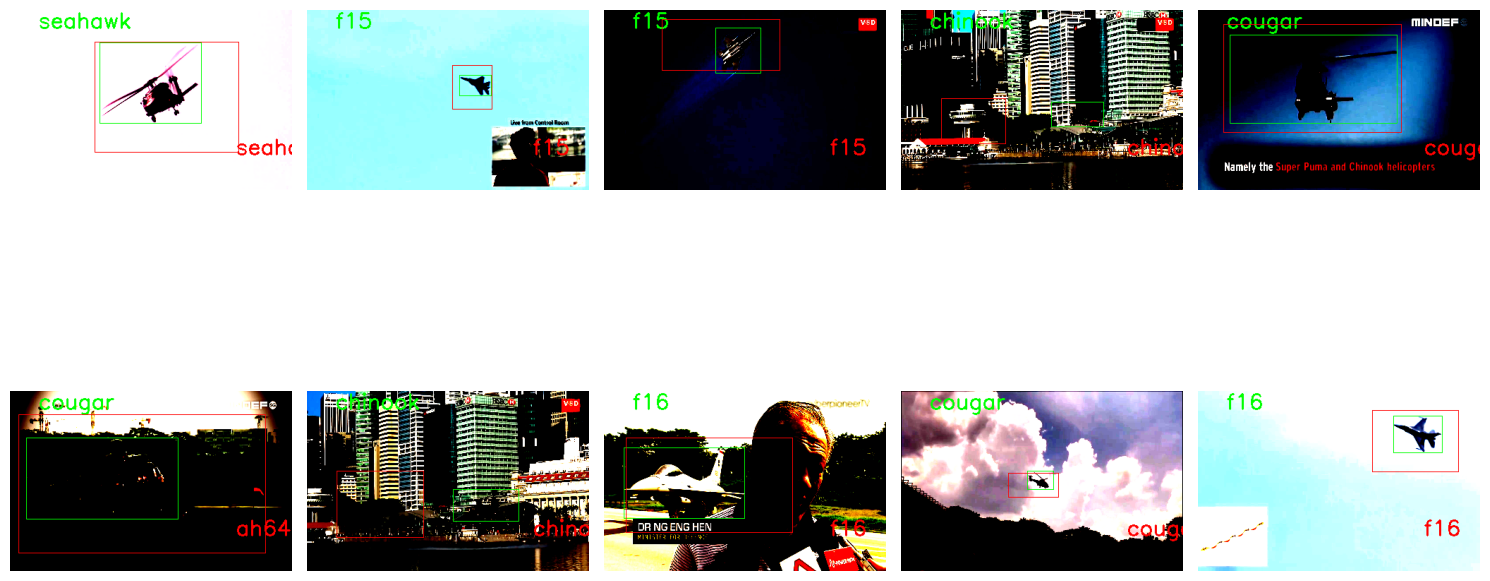


Generating submission file...

Submission file saved to /kaggle/working/submission.csv

Preview:
                    class  xmin  ymin  xmax  ymax
filename                                         
image_00219.jpeg  chinook   398   112  1043   566
image_00034.jpeg      f16   335   345   964   617
image_00265.jpeg     ah64   455   210   763   364
image_00042.jpeg      f16   290   296   704   465
image_00294.jpeg     ah64    70    40   943   516


In [ ]:
if __name__ == '__main__':
    trained_model, eval_transforms = main()

    while True:
        response = "y"
        if response in ['y', 'n']:
            break
        print("Invalid input. Please enter 'y' or 'n'")

    if response == 'y':
        print("\nGenerating submission file...")
        generate_submission(trained_model, eval_transforms)

        print("\nSaving model and weights.")
        model_path = os.path.join(WORK_DIR, 'model.pth')
        weights_path = os.path.join(WORK_DIR, 'weigths.pth')
        torch.save(trained_model, model_path)
        torch.save(trained_model.state_dict(), weights_path)
        print(f"Model saved to {model_path}")
    else:
        print("\nSubmission generation skipped.")

    print("\nModel summary")
    print(summary(trained_model,(3,TARGET_SIZE[1],TARGET_SIZE[0])))
